In [1]:
import cv2
import mahotas
import matplotlib.pyplot as plt
import numpy as np
import skopt
import warnings

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from skopt import BayesSearchCV
from skopt.plots import plot_objective
import shap

c:\Users\michu\source\repos\ML-Zernike\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Source: https://github.com/credo-science/CREDO-ML/blob/main/offline_trigger/Wavelet_BINARY_ALFA.ipynb
def loadData(path, verbose=True):

  import cv2
  import glob

  dots = []
  lines = []
  worms = []
  artefacts = []

  for img in glob.glob(path+"hits_votes_4_Dots/*.png"):
      n = cv2.imread(img)
      dots.append(n)
  target_dots = ['dots' for _ in dots]

  for img in glob.glob(path+"hits_votes_4_Lines/*.png"):
      n = cv2.imread(img)
      lines.append(n)
  target_lines = ['lines' for _ in lines]

  for img in glob.glob(path+"hits_votes_4_Worms/*.png"):
      n = cv2.imread(img)
      worms.append(n)
  target_worms = ['worms' for _ in worms]

#   for img in glob.glob(path+"artefacts/*.png"):
#       n = cv2.imread(img)
#       artefacts.append(n)
#   target_artefacts = [3 for _ in artefacts]

  images=dots+lines+worms#+artefacts

  #target_signals_binary = [0 for _ in (dots+lines+worms)]
  #target_artefacts_binary = [1 for _ in artefacts]

  #targets=target_signals_binary+target_artefacts_binary
  targets=target_dots+target_lines+target_worms#+target_artefacts

  if verbose:
    print(len(images),len(targets))
    print(images[0].shape)
    print(len(dots), len(lines), len(worms), len(artefacts))


  return (images, targets)

In [3]:
def pca_reduction(X: np.ndarray, n_components: int, verbose: bool = True):
    """Function for Principal Component Analysis (PCA).

    Args:
        X (np.ndarray): Input data.
        n_components (int): Number of components for PCA reduction.
        verbose (bool): When True print sum of explained variance ratio.

    Returns:
        ret (np.ndarray): Data after PCA.
    """
    X_norm = preprocessing.normalize(X)

    pca = PCA(n_components=n_components)
    pca.fit(X_norm)

    ret = pca.transform(X_norm)

    if verbose:
        print(f'Sum of explained variance ratio: {pca.explained_variance_ratio_.sum()}')

    return ret

In [4]:
def preprocess_data(X: list, blur_ksize: tuple, thresh_min: int, thresh_max: int, zernike_radius: int, zernike_degree: int, pca_num_components: int, pca_verbose: bool) -> np.ndarray:
    """Preprocess data.

    Args:
        X (list): Input data.
        blur_ksize (tuple): Blur kernel size.
        thresh_min (int): Threshold minimal value.
        thresh_max (int): Threshold maximal value.
        zernike_radius (int): Zernike moments radius.
        zernike_degree (int): Zernike moments degree.
        pca_num_components (int): Number of components for PCA reduction.
        pca_verbose (bool): When True PCA prints sum of explained variance ratio.

    Returns:
        ret (np.ndarray): Preprocessed data.
    """
    dim: int = mahotas.features.zernike_moments(
        cv2.cvtColor(X[0], cv2.COLOR_RGB2GRAY), zernike_radius, zernike_degree
        ).shape[0]
    
    ret: np.ndarray = np.zeros((len(X), dim))
    for i in range(len(X)):

        # Preprocess image before extracting zernike moments
        img: np.ndarray = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
        img = cv2.GaussianBlur(img, blur_ksize, 0)
        _, img = cv2.threshold(img, thresh_min, thresh_max, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Extract zernike moments
        zernike: np.ndarray = mahotas.features.zernike_moments(img, zernike_radius, zernike_degree)
        
        ret[i,:] = zernike
    
    # PCA dimensionality reduction
    ret = pca_reduction(ret, pca_num_components, pca_verbose)
        
    return ret

In [5]:
def plot_confusion_matrix(y_test: list, y_pred: list, model: any):
    """Display confusion matrix.

    Args:
        y_test (list): Target classes.
        y_pred (list): Predicted classes.
        model (ClassifierMixin): Model used for prediction.
    """
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

In [6]:
def jackknife(X: np.ndarray, y: np.ndarray, model: any, n_samples: int, seed: int) -> float:
    """Function for Jackknife resampling method.

    Args:
        X (np.ndarray): Input data.
        y (np.ndarray): Input classes.
        model (any): Selected model.
        n_samples (int): Number of samples for Jackknife.
    """
    
    p = np.random.RandomState(seed=seed).permutation(len(X))
    X = X[p] 
    y = y[p]
    
    model.fit(X, y)
    all_data_score = model.score(X, y)

    sample_size = int(len(X)/n_samples)
    
    scores = np.zeros((n_samples,1), dtype=np.float16)
    for i in range(n_samples):
        start = i*sample_size
        stop = (i+1)*sample_size

        X_train = np.delete(X, np.s_[start:stop], axis=0)
        y_train = np.delete(y, np.s_[start:stop], axis=0)

        X_test = X[start:stop]
        y_test = y[start:stop]
        
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        scores[i] = all_data_score - score
    
    return np.mean(scores)

In [8]:
def bootstrap(X: np.ndarray, y: np.ndarray, model: any, n_samples: int) -> tuple(np.ndarray, np.ndarray):
    """Function for Bootstrap resampling method.

    Args:
        X (np.ndarray): Input data.
        y (np.ndarray): Input classes.
        model (any): Selected model.
        n_samples (int): Number of samples for Bootstrap.

    Returns:
        means (np.ndarray): Means for all classes.
        stds (np.ndarray): Standard deviation for all classes.
    """
    classes = np.unique(y)
    num_classes = classes.shape[0]
    accuracy = np.zeros((1 + num_classes, n_samples), dtype=np.float16)
    for i in range(n_samples):
        X_bs, y_bs = resample(X, y, replace=True)
        # make predictions
        y_hat = model.predict(X_bs)
        # evaluate model
        score = accuracy_score(y_bs, y_hat)
        accuracy[0, i] = score
        for j in range(num_classes):
            class_indices = np.where(y_bs == classes[j])[0]
            X_class, y_class = X_bs[class_indices], y_bs[class_indices]
            y_class_pred = model.predict(X_class)
            accuracy[j+1, i] = accuracy_score(y_class_pred, y_class)
    
    fig, axs = plt.subplots(num_classes + 1, figsize=(10,6))

    classes = np.insert(classes, 0, 'all')
    
    means = np.zeros((1 + num_classes), dtype=np.float16)
    stds = np.zeros((1 + num_classes), dtype=np.float16)
    
    for i in range(num_classes+1):
        unique, counts = np.unique(accuracy[i], return_counts=True)
        counts = (counts-np.min(counts))/(np.max(counts)-np.min(counts))
        axs[i].bar(unique, counts, width = 0.005)
        axs[i].set_title(classes[i])
        axs[i].xaxis.set_ticks(np.arange(0, 1, 0.1))

        means[i] = np.mean(accuracy[i])
        stds[i] = np.std(accuracy[i])

    fig.tight_layout()
    fig.show()

    return means, stds

TypeError: tuple expected at most 1 arguments, got 2

In [9]:
path="../data/hit-images-final/"

X_, y = loadData(path, False)

In [10]:
blur_ksize = (5, 5)
thresh_min = 0
thresh_max = 255 
zernike_radius = 30 
zernike_degree = 28
pca_num_components = 8
pca_verbose = True
jk_samples = 5
jk_seed = 0
bs_samples = 10000

X = preprocess_data(X_, blur_ksize, thresh_min, thresh_max, zernike_radius, zernike_degree, pca_num_components, pca_verbose)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Sum of explained variance ratio: 0.9377061093551787


# SVC

## Bayesian optimization

In [15]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
opt = BayesSearchCV(
    SVC(), 
    {
        'C': [1.0],
        'gamma': [1e-6],
        'degree': [1],
        'kernel': ['linear'],
    },
    n_iter = 100,
    cv = 5,
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

KeyboardInterrupt: 

IndexError: list index out of range

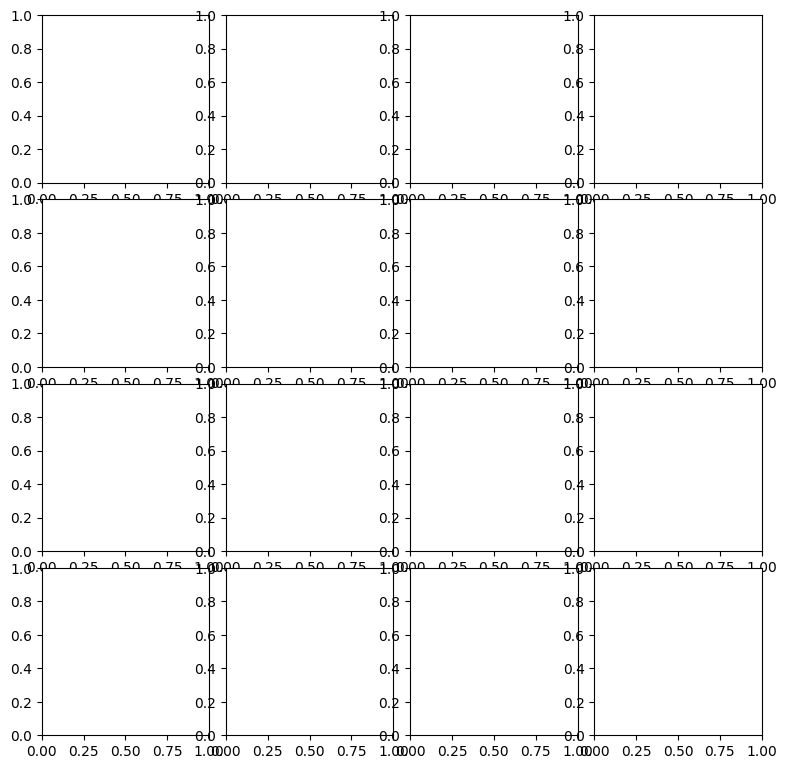

In [ ]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

## Optimized model prediction

Training accuracy: 0.9147208121827411
Test accuracy: 0.9433198380566802


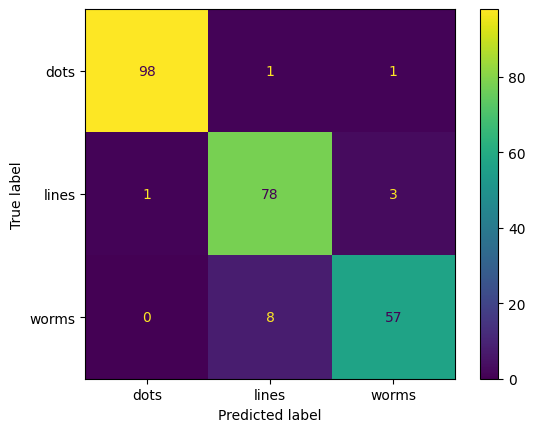

In [19]:
#svc = SVC(**opt.best_params_)
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
train_accuracy = accuracy_score(y_train, svc.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')
plot_confusion_matrix(y_test, y_pred, svc)

## Bootstrap

all: mean = 0.95703125, std = 0.005767822265625
dots: mean = 0.9814453125, std = 0.005817413330078125
lines: mean = 0.94384765625, std = 0.01163482666015625
worms: mean = 0.9306640625, std = 0.01461029052734375


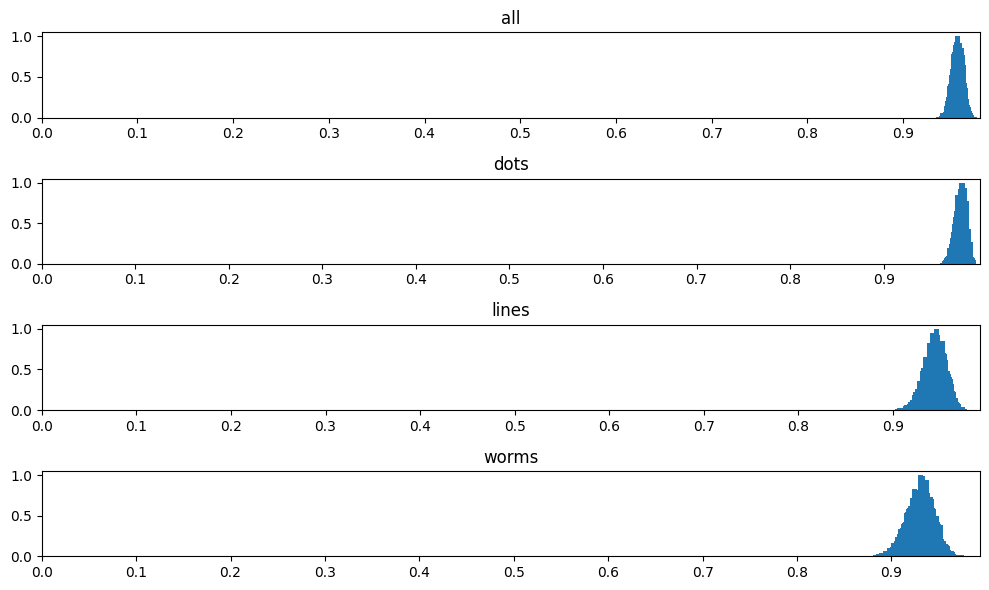

In [71]:
svc_means, svc_stds = bootstrap(X, np.asarray(y), svc, bs_samples)
classes = np.insert(np.unique(y), 0, 'all')
for i in range(classes.shape[0]):
    print(f'{classes[i]}: mean = {svc_means[i]}, std = {svc_stds[i]}')

## Jackknife cross-validation

In [21]:
svc_jk = jackknife(X, np.asarray(y), svc, jk_samples, jk_seed)
print(f'Jackknife score: {svc_jk}')

Jackknife score: 0.0350341796875


# KNN

## Bayesian optimization

In [19]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
opt = BayesSearchCV(
    KNeighborsClassifier(), 
    {
        "n_neighbors": (3, 5, 7, 9, 11),
        "weights": ["uniform", "distance"],
        "algorithm": [ "ball_tree", "kd_tree", "brute"],
        "p": (1,2),
        "leaf_size": (10, 20, 30, 40, 50)
    },
    n_iter = 100,
    cv = 5
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9299492385786803
test. score 0.9068825910931174
best params OrderedDict([('algorithm', 'brute'), ('leaf_size', 50), ('n_neighbors', 3), ('p', 2), ('weights', 'distance')])


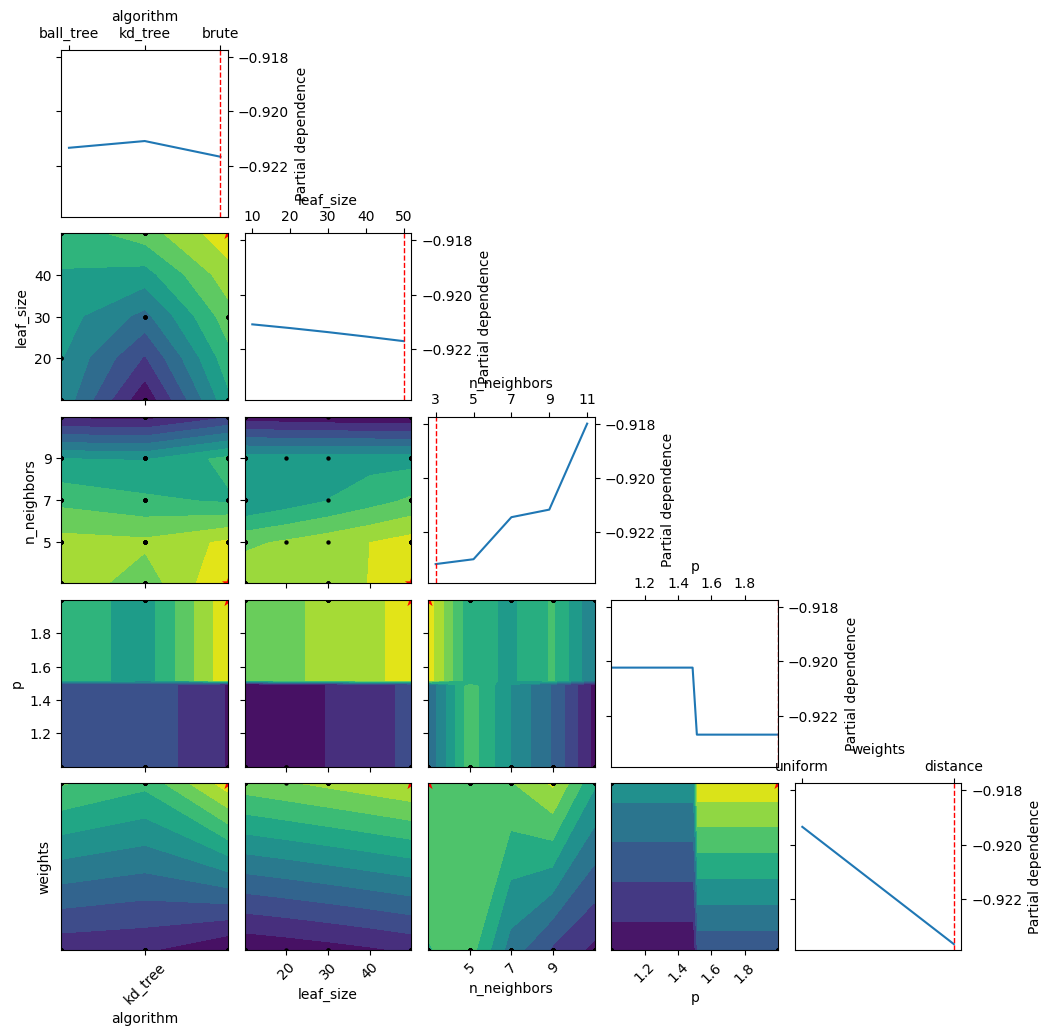

In [20]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

## Optimized model prediction

Training accuracy: 0.9512690355329949
Test accuracy: 0.9271255060728745


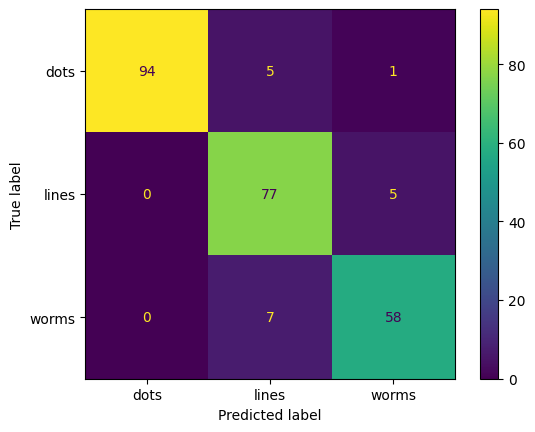

In [25]:
#knn = KNeighborsClassifier(**opt.best_params_)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
train_accuracy = accuracy_score(y_train, knn.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')
plot_confusion_matrix(y_test, y_pred, knn)

## Shap

In [36]:
shap.initjs()

explainer = shap.KernelExplainer(knn.predict_proba, X_train[:20])
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

100%|██████████| 247/247 [00:24<00:00, 10.02it/s]


## Bootstrap

all: mean = 0.974609375, std = 0.004428863525390625
dots: mean = 0.99072265625, std = 0.00417327880859375
lines: mean = 0.966796875, std = 0.00907135009765625
worms: mean = 0.95703125, std = 0.01149749755859375


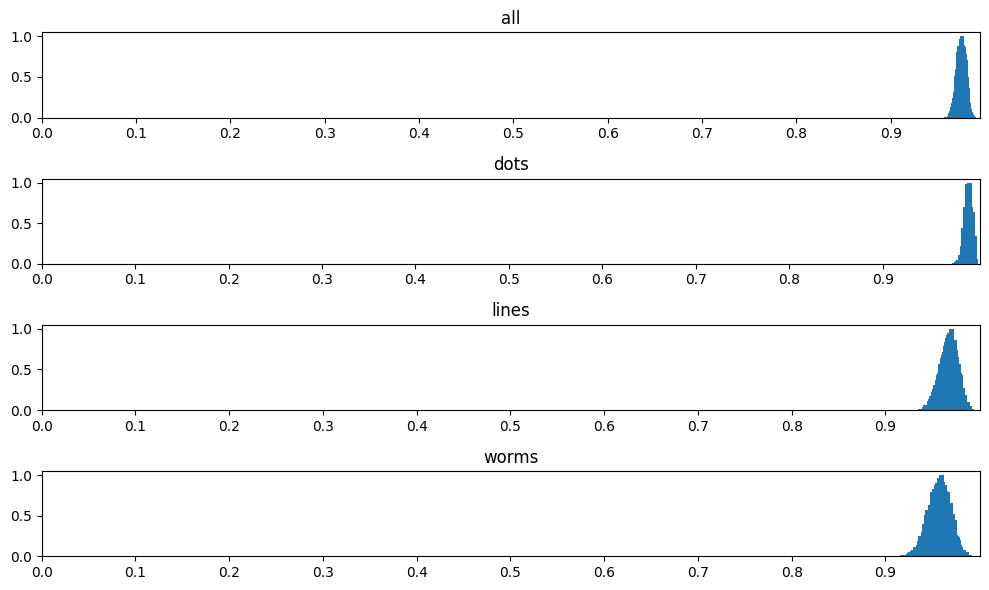

In [75]:
knn_means, knn_stds = bootstrap(X, np.asarray(y), knn, bs_samples)
classes = np.insert(np.unique(y), 0, 'all')
for i in range(classes.shape[0]):
    print(f'{classes[i]}: mean = {knn_means[i]}, std = {knn_stds[i]}')

## Jackknife cross-validation

In [22]:
knn_jk = jackknife(X, np.asarray(y), knn, jk_samples, jk_seed)
print(f'Jackknife score: {knn_jk}')

Jackknife score: 0.069091796875


# RFC

## Bayesian optimization

In [11]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
opt = BayesSearchCV(
    RandomForestClassifier(), 
    {
        'n_estimators': (10, 50, 100, 200),
        'criterion': ['gini', 'entropy'],
        'max_features': ["sqrt", "log2", None],
    },
    n_iter = 100,
    cv = 5,
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9411167512690357
test. score 0.9311740890688259
best params OrderedDict([('criterion', 'entropy'), ('max_features', 'sqrt'), ('n_estimators', 100)])


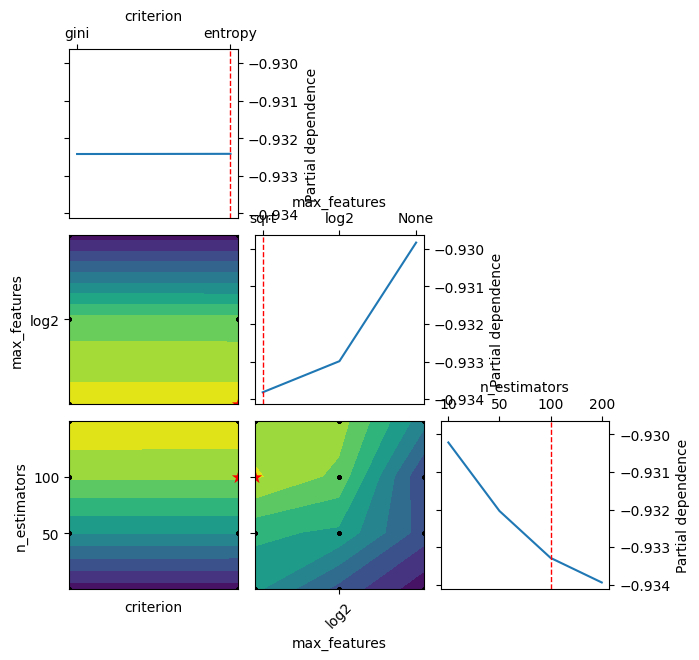

In [12]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

## Optimized model prediction

Training accuracy: 0.9928934010152284
Test accuracy: 0.9311740890688259


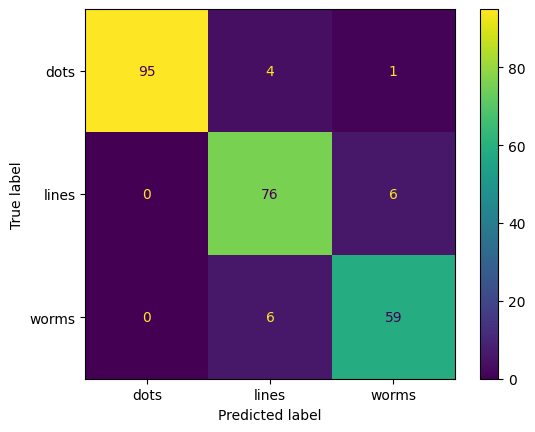

In [38]:
#rfc = RandomForestClassifier(**opt.best_params_)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
train_accuracy = accuracy_score(y_train, rfc.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')
plot_confusion_matrix(y_test, y_pred, rfc)

## Shap

In [39]:
shap.initjs()

explainer = shap.KernelExplainer(rfc.predict_proba, X_train[:20])
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

100%|██████████| 247/247 [00:32<00:00,  7.70it/s]


## Bootstrap

all: mean = 0.98046875, std = 0.003997802734375
dots: mean = 0.98681640625, std = 0.00492095947265625
lines: mean = 0.974609375, std = 0.00798797607421875
worms: mean = 0.97705078125, std = 0.008575439453125


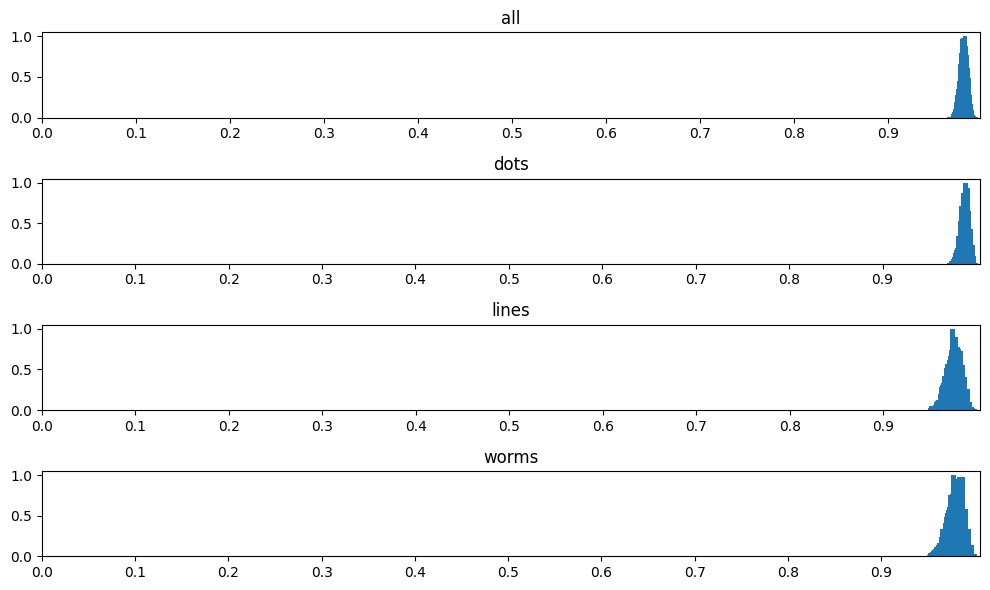

In [77]:
rfc_means, rfc_stds = bootstrap(X, np.asarray(y), rfc, bs_samples)
classes = np.insert(np.unique(y), 0, 'all')
for i in range(classes.shape[0]):
    print(f'{classes[i]}: mean = {rfc_means[i]}, std = {rfc_stds[i]}')

## Jackknife cross-validation

In [23]:
rfc_jk = jackknife(X, np.asarray(y), rfc, jk_samples, jk_seed)
print(f'Jackknife score: {rfc_jk}')

Jackknife score: 0.0650634765625


# MLP

## Bayesian optimization

In [10]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')
warnings.filterwarnings('ignore', message='.*converge.*')
opt = BayesSearchCV(
    MLPClassifier(max_iter=1000), 
    {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [1e-5, 1e-4, 1e-3],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
    },
    n_iter = 100,
    cv = 5,
)
opt.fit(X_train, y_train)
print("val. score %s" %opt.best_score_)
print("test. score %s" %opt.score(X_test, y_test))

print("best params %s" %str(opt.best_params_))

val. score 0.9411167512690355
test. score 0.9109311740890689
best params OrderedDict([('activation', 'relu'), ('alpha', 0.001), ('learning_rate', 'invscaling'), ('solver', 'adam')])


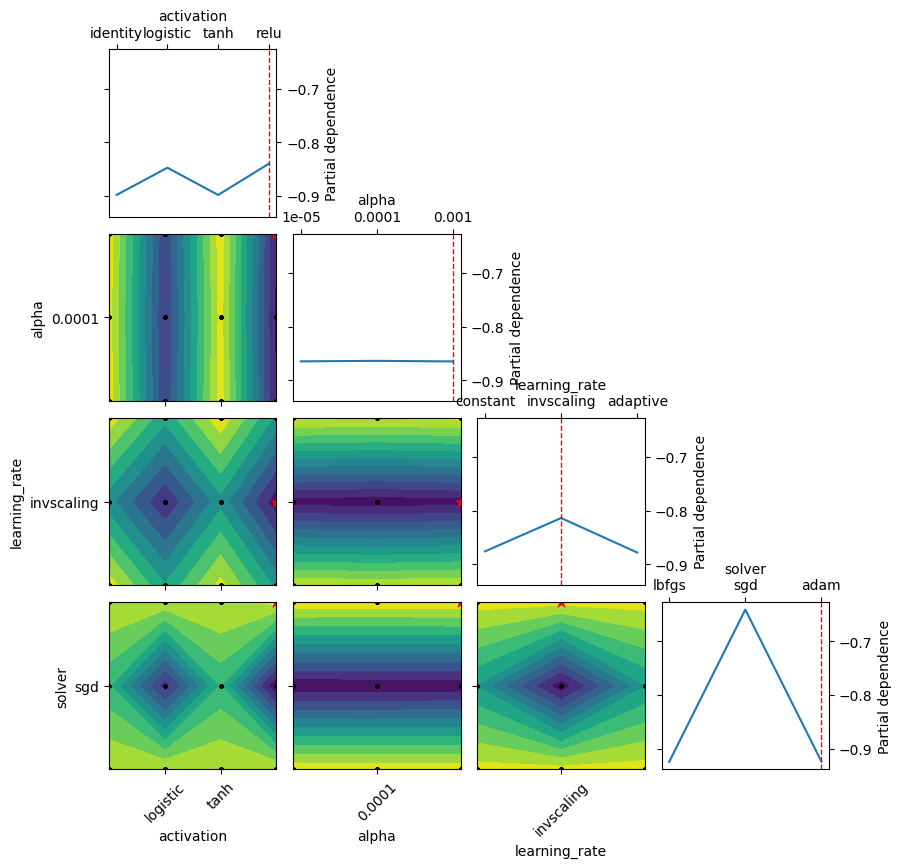

In [11]:
k = plot_objective(opt.optimizer_results_[0], n_minimum_search=int(1e8))
plt.show()

## Optimized model prediction

Training accuracy: 0.9583756345177665
Test accuracy: 0.9109311740890689


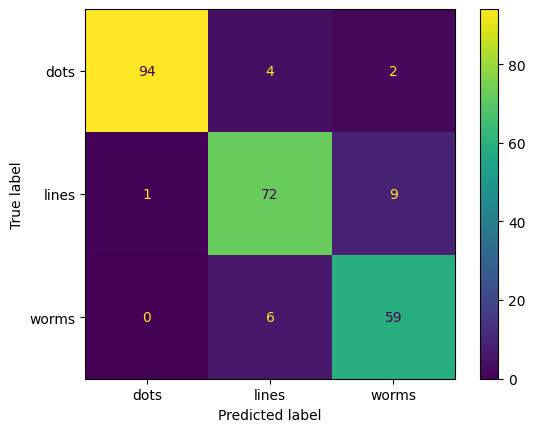

In [78]:
mlp = MLPClassifier(**opt.best_params_, max_iter=1000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
train_accuracy = accuracy_score(y_train, mlp.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Training accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')
plot_confusion_matrix(y_test, y_pred, mlp)

## Bootstrap

all: mean = 0.94873046875, std = 0.006237030029296875
dots: mean = 0.98486328125, std = 0.005260467529296875
lines: mean = 0.92626953125, std = 0.013153076171875
worms: mean = 0.91455078125, std = 0.0160675048828125


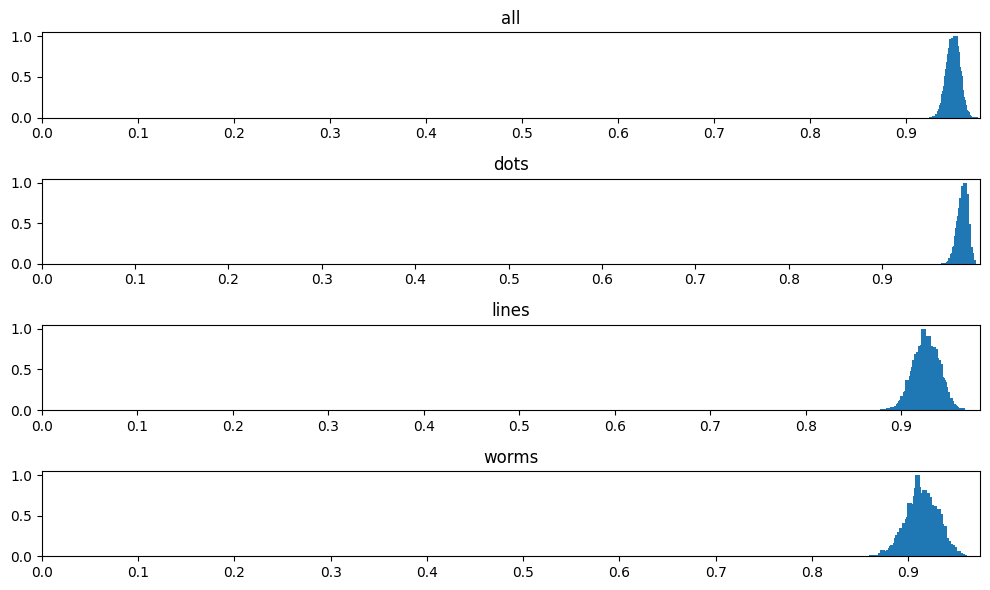

In [79]:
mlp_means, mlp_stds = bootstrap(X, np.asarray(y), mlp, bs_samples)
classes = np.insert(np.unique(y), 0, 'all')
for i in range(classes.shape[0]):
    print(f'{classes[i]}: mean = {mlp_means[i]}, std = {mlp_stds[i]}')

## Jackknife cross-validation

In [26]:
mlp_jk = jackknife(X, np.asarray(y), mlp, jk_samples, jk_seed)
print(f'Jackknife score: {mlp_jk}')

Jackknife score: 0.0244598388671875


# Models comparison

In [27]:
print('Jackknife scores:')
print(f'SVC: {svc_jk}')
print(f'KNN: {knn_jk}')
print(f'RFC: {rfc_jk}')
print(f'MLP: {mlp_jk}')

Jackknife scores:
SVC: 0.0350341796875
KNN: 0.069091796875
RFC: 0.0650634765625
MLP: 0.0244598388671875


In [14]:
print("Bootstrap scores (mean, std):")
print(f'       | {"SVC":^14} | {"KNN":^14} | {"RFC":^14} | {"MLP":^14}')
for i in range(classes.shape[0]):
    print(f'{classes[i]+":":<6} | {svc_means[i]:.4f}, {svc_stds[i]:.4f} | {knn_means[i]:.4f}, {knn_stds[i]:.4f} | {rfc_means[i]:.4f}, {rfc_stds[i]:.4f} | {mlp_means[i]:.4f}, {mlp_stds[i]:.4f}')

Bootstrap scores (mean, std):
       |      SVC       |      KNN       |      RFC       |      MLP      
all:   | 0.9570, 0.0058 | 0.9746, 0.0044 | 0.9805, 0.0040 | 0.9487, 0.0062
dots:  | 0.9814, 0.0058 | 0.9907, 0.0042 | 0.9868, 0.0049 | 0.9849, 0.0053
lines: | 0.9438, 0.0116 | 0.9668, 0.0091 | 0.9746, 0.0080 | 0.9263, 0.0132
worms: | 0.9307, 0.0146 | 0.9570, 0.0115 | 0.9771, 0.0086 | 0.9146, 0.0161
